In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p
from dataloader import *
from utils import *
from models import *
from train_test import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS))

rcParams['figure.figsize'] = 12, 8


1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64


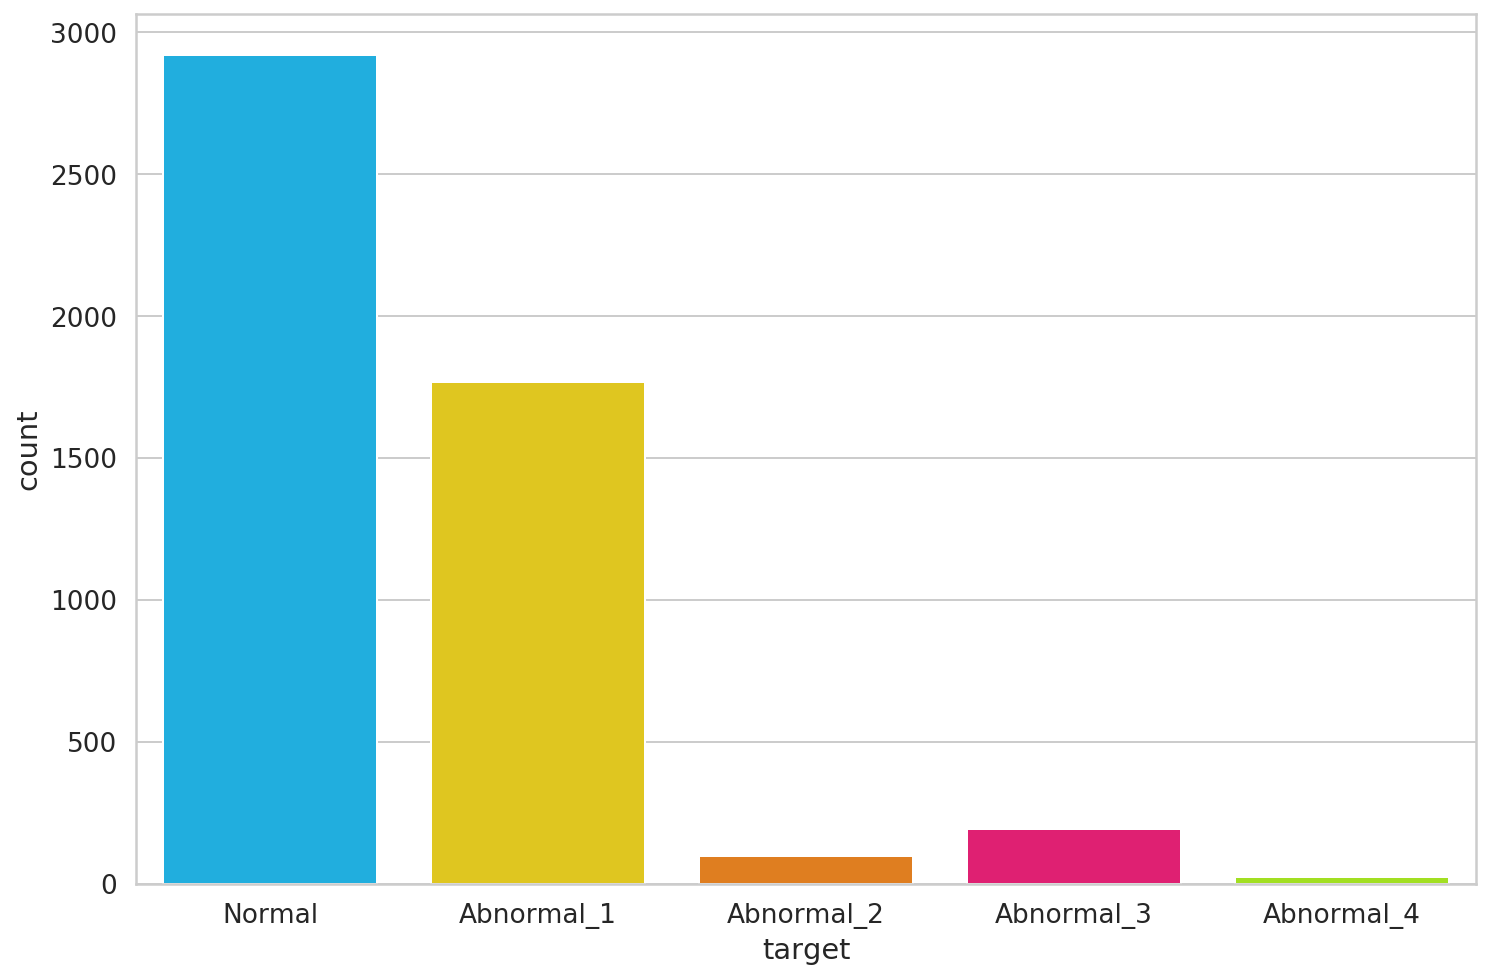

In [2]:
# load data and display its class
df = load_data()
print(df.target.value_counts())
ax = sns.countplot(df.target)
class_names = ['Normal','Abnormal_1','Abnormal_2','Abnormal_3','Abnormal_4']
ax.set_xticklabels(class_names);

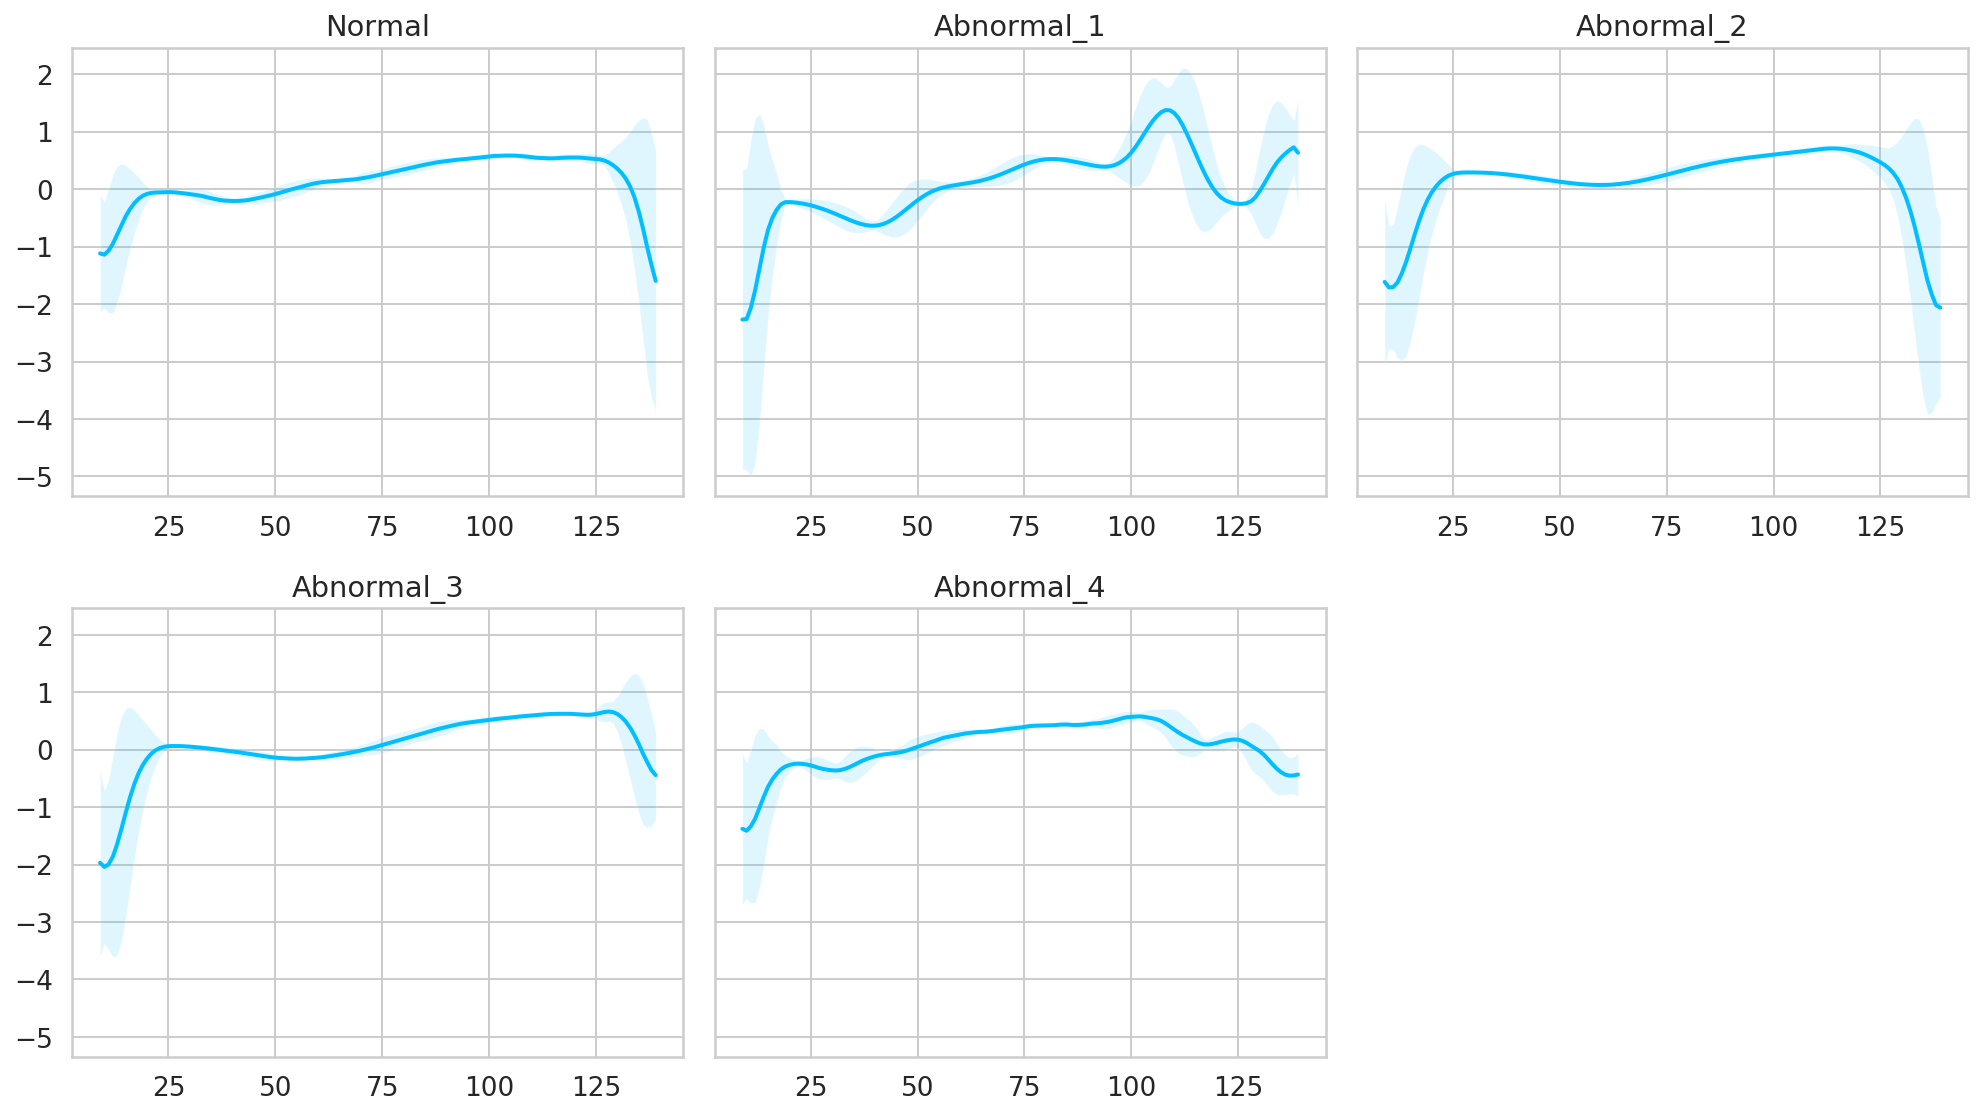

In [3]:
# Plot time series data for each class
plot_time_series_data(df, class_names)

In [4]:
# Preprocess data
train_df, val_df, test_df = data_preprocess(df)

# create dataset
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
anomaly_df = df[df.target != str(1)].drop(labels='target', axis=1)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [5]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss(reduction='sum').to(device)

In [6]:
# train
model, history = train_lstm(
    model, 
    train_dataset, 
    val_dataset, 
    n_epochs=30,
    optimizer = optimizer,
    criterion = criterion
)

Epoch 1: train loss 60.80929132416621 val loss 57.73308986776016
Epoch 2: train loss 53.11759511551459 val loss 49.387331326802574
Epoch 3: train loss 48.64351892655105 val loss 40.313903130737
Epoch 4: train loss 35.27000074692916 val loss 37.14474134351693
Epoch 5: train loss 30.384756946767933 val loss 25.494134035764954
Epoch 6: train loss 28.28814155243704 val loss 24.731199757725584
Epoch 7: train loss 27.071258023362088 val loss 26.76620614528656
Epoch 8: train loss 25.812842645583878 val loss 26.094618037635204
Epoch 9: train loss 23.488441320660282 val loss 23.743061675744897
Epoch 10: train loss 22.962656994805346 val loss 23.354614458832085
Epoch 11: train loss 21.952004465760716 val loss 19.265364364081737
Epoch 12: train loss 21.97862527263241 val loss 20.01079548807705
Epoch 13: train loss 21.01720046711172 val loss 20.739459140627993
Epoch 14: train loss 19.78780964150929 val loss 20.527569123342925
Epoch 15: train loss 22.878780231434988 val loss 20.80528000055575
Epoch

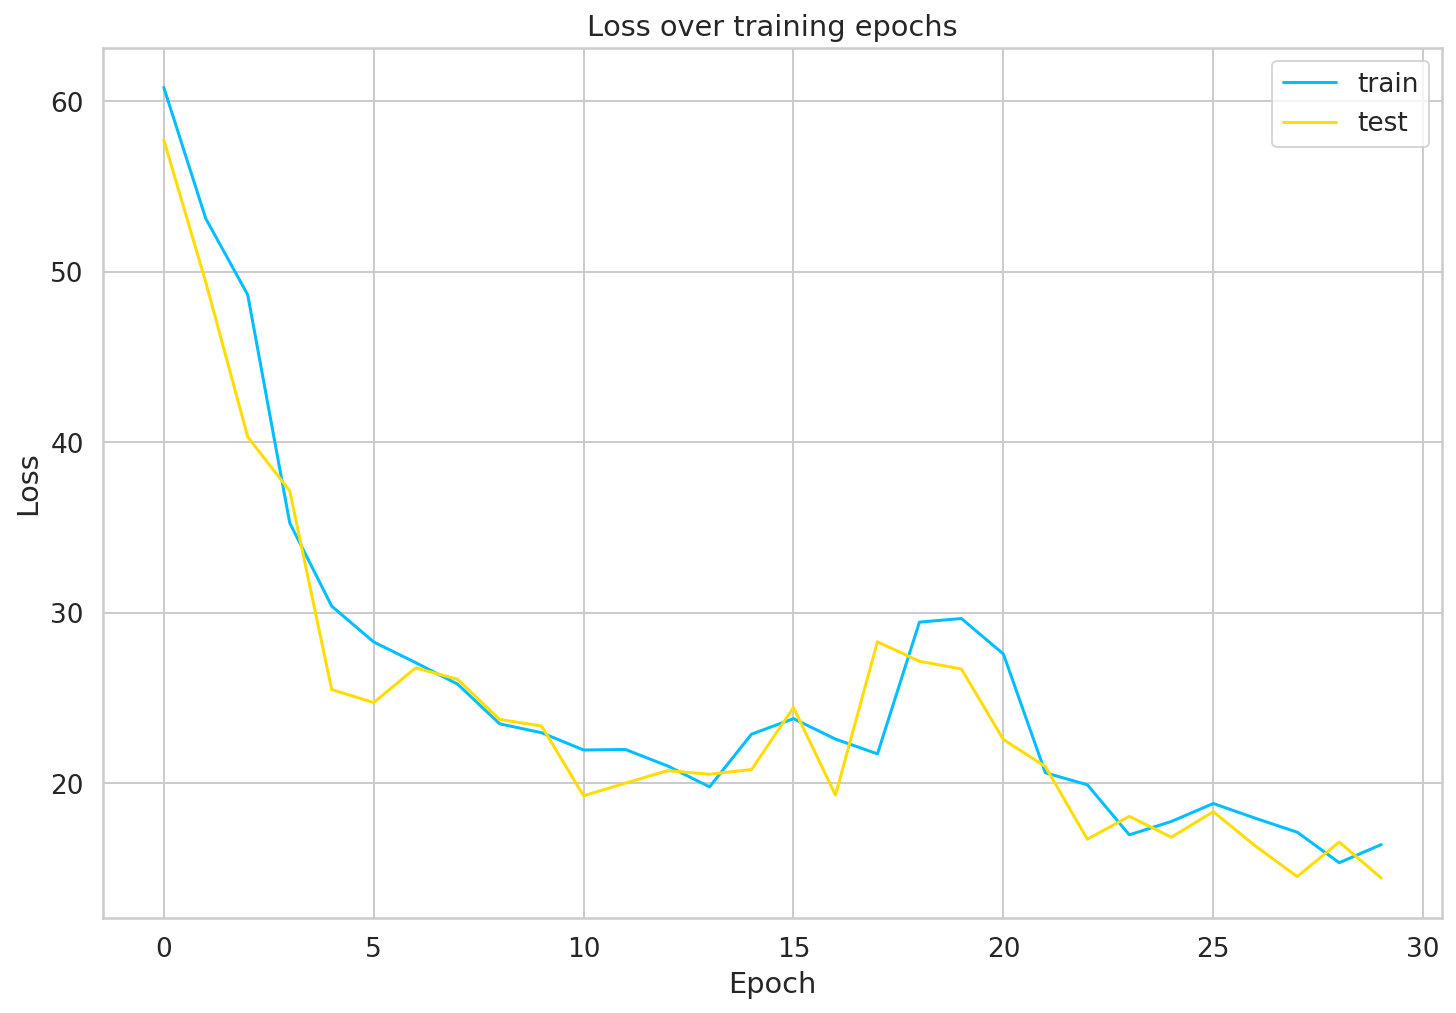

In [7]:
# plot loss
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

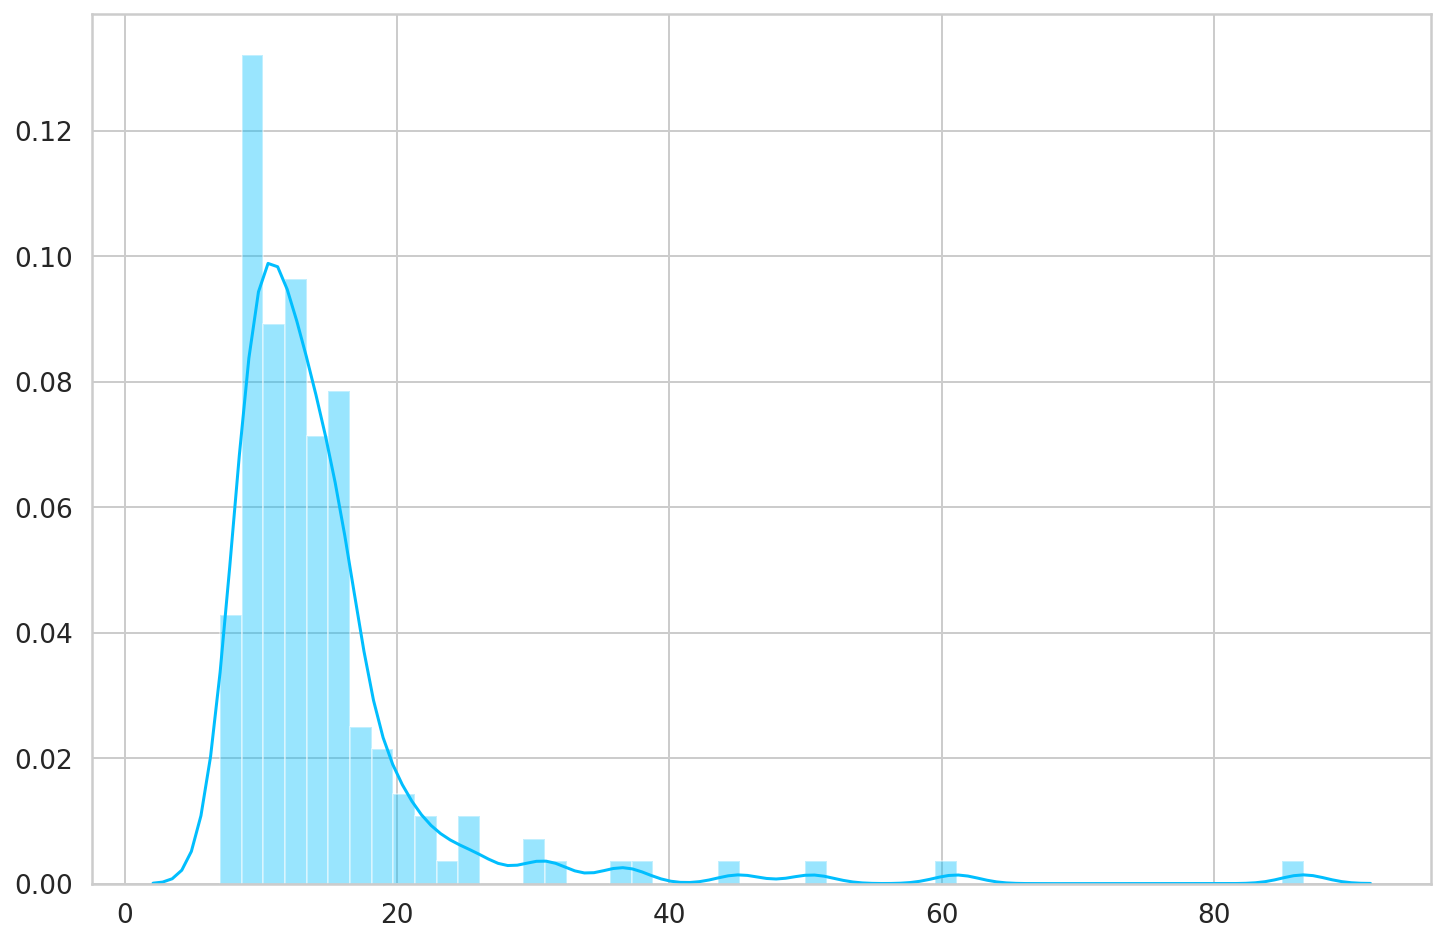

In [45]:
# Plot loss of normal data to get threshold
predictions, pred_losses = predict_lstm(model, test_normal_dataset, criterion)

sns.distplot(pred_losses, bins=50, kde=True);

In [46]:
# Get threshold
threshold = 25

In [47]:
# Get TP and FP
TP = sum(l <= threshold for l in pred_losses)
FP = len(test_normal_dataset) - TP
print(f'Correct normal predictions: {TP}/{len(test_normal_dataset)}')


Correct normal predictions: 165/176


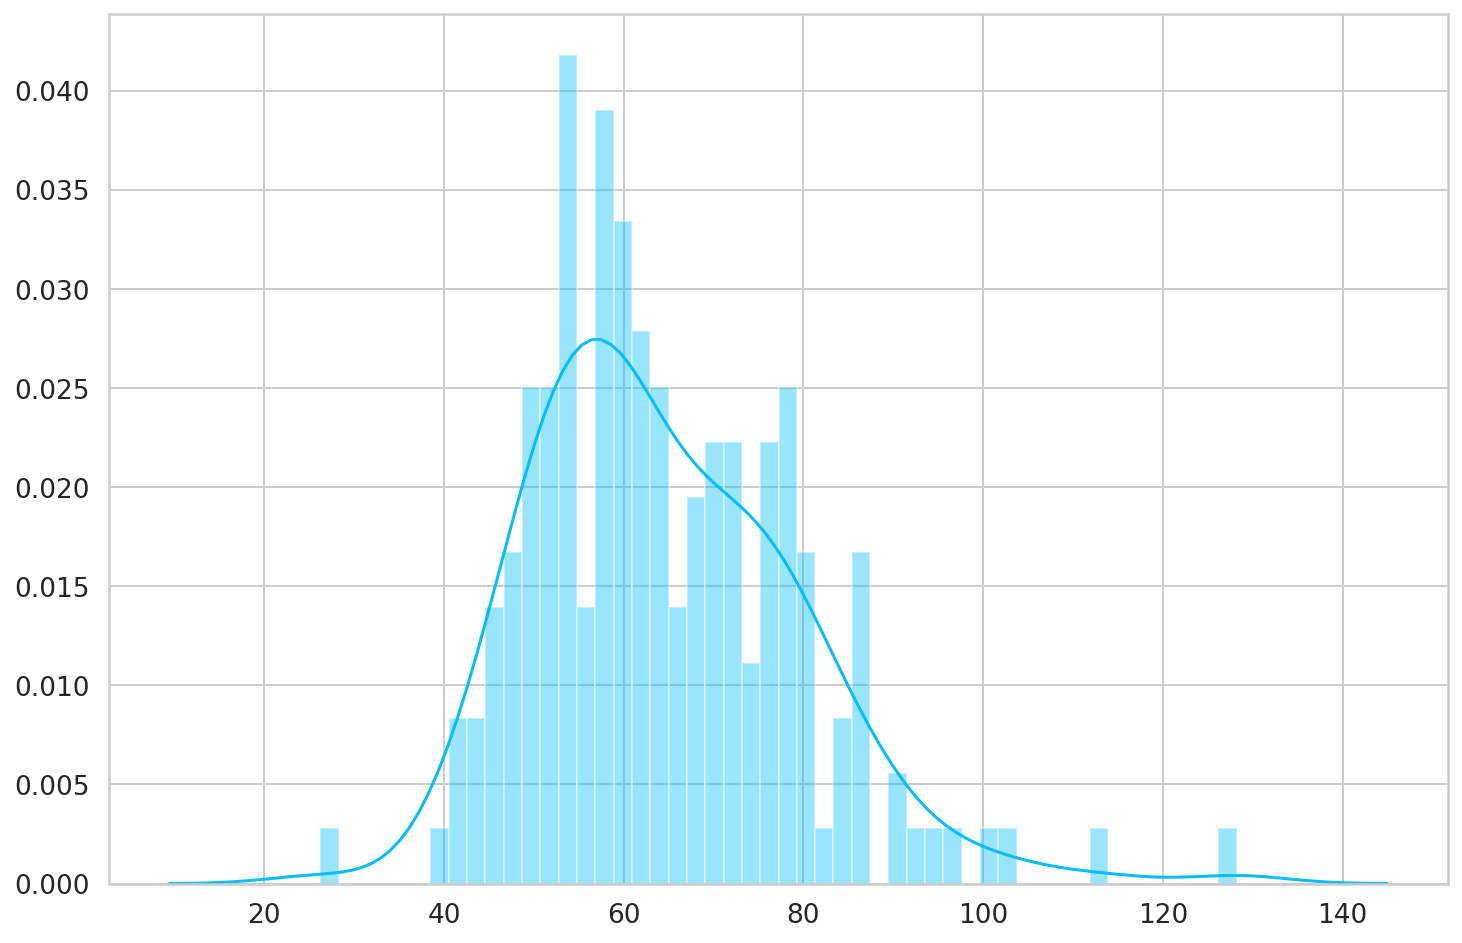

In [48]:
# Plot loss of abnormal data
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict_lstm(model, anomaly_dataset, criterion)
sns.distplot(pred_losses, bins=50, kde=True);

In [49]:

# Get TN and FN
TN = sum(l > threshold for l in pred_losses)
FN = len(anomaly_dataset) - TN
print(f'Correct anomaly predictions: {TN}/{len(anomaly_dataset)}')


Correct anomaly predictions: 176/176


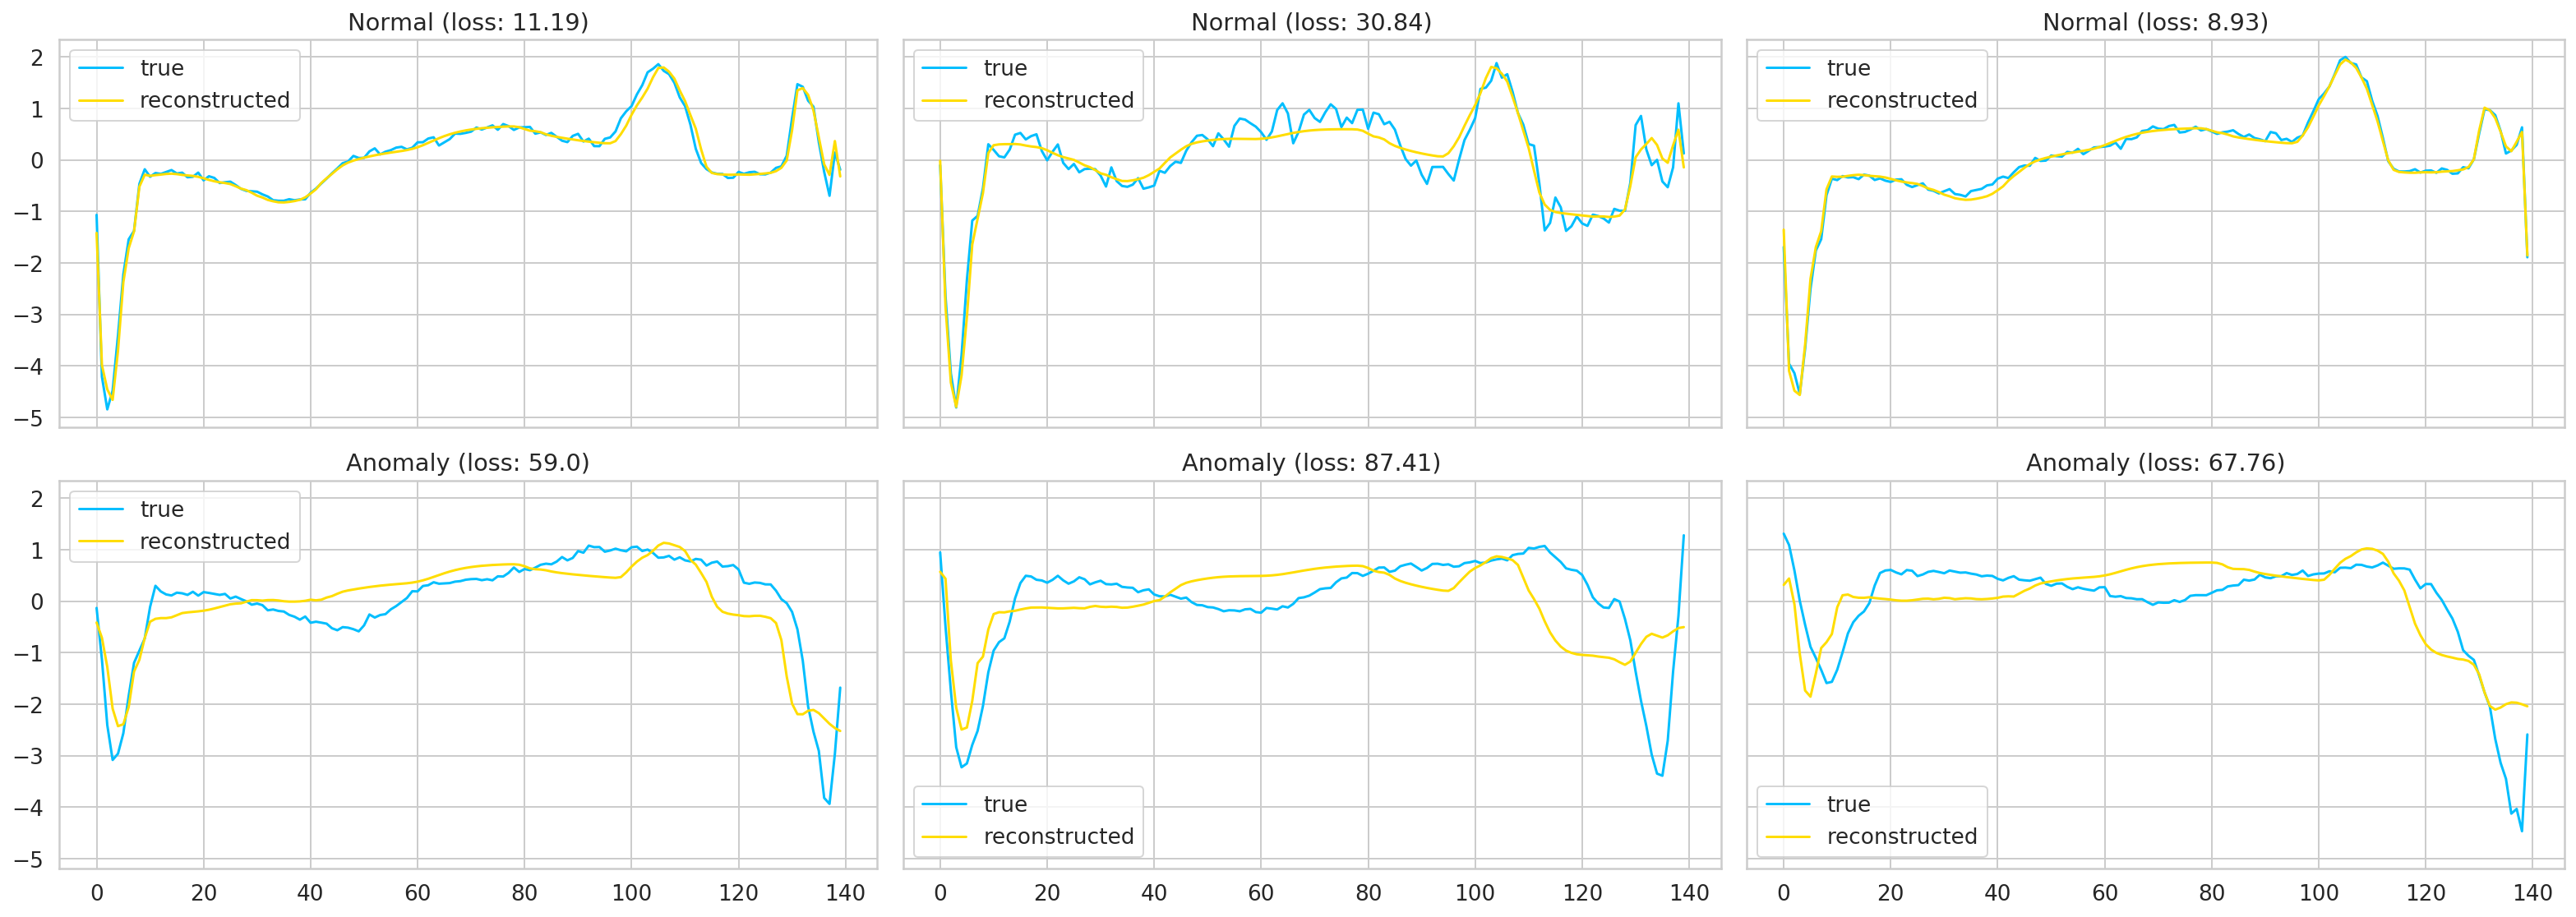

In [29]:
# Plot raw and reconstructed data for noraml and abnoraml data
fig, axs = plt.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:3]):
    plot_prediction(data, model, criterion, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:3]):
    plot_prediction(data, model, criterion, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

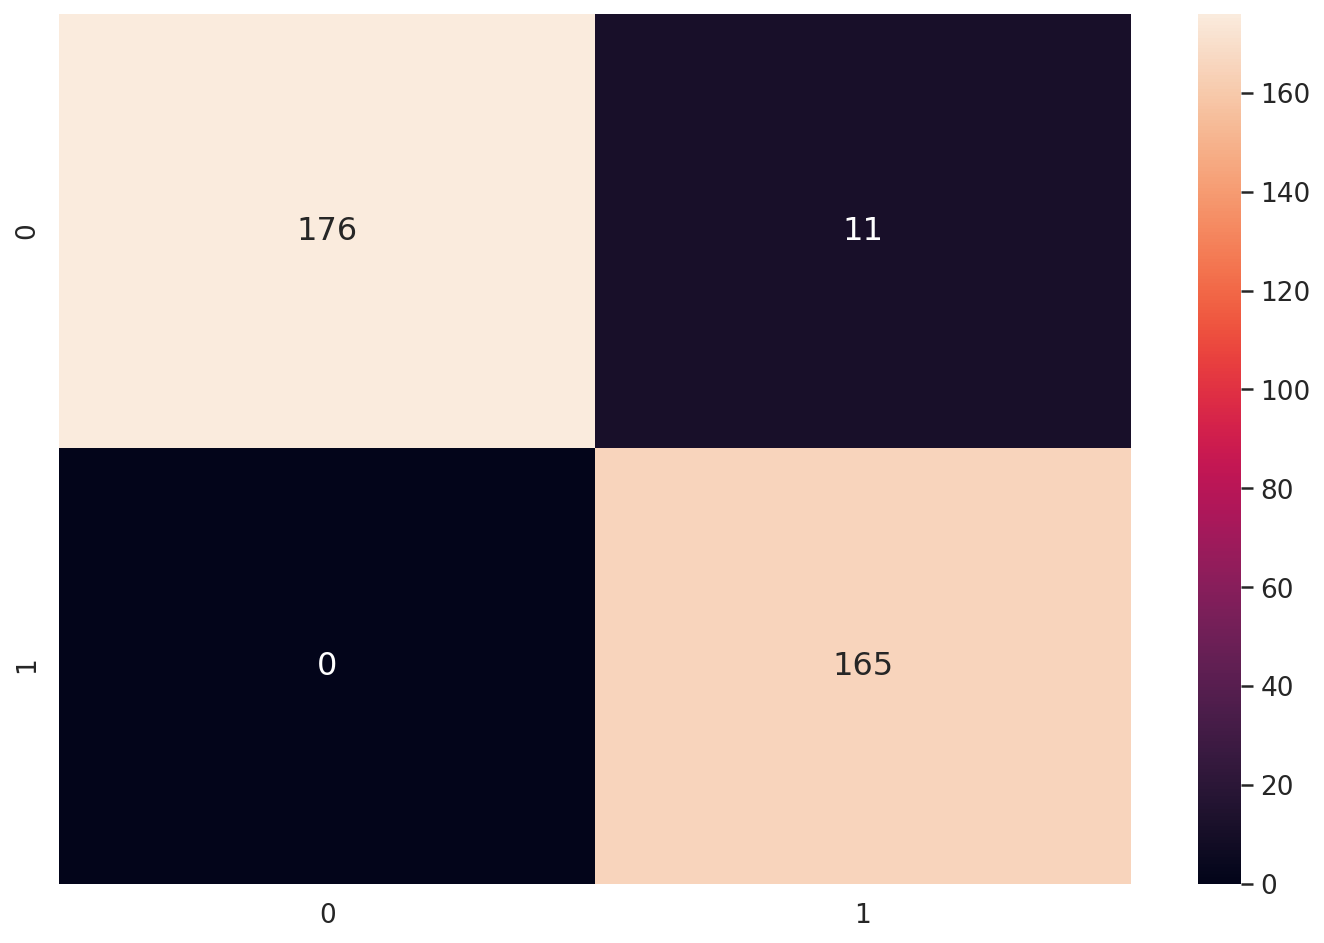

In [50]:
# Confusion matrix
conf = np.array([[TN,FP],[FN,TP]])
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')